# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv',
               '../../data/cleaned/utah_2017_bird.csv']

test_files = ['../../data/cleaned/utah_2018_vineyard.csv', 
               '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']
x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

RFU_THRESHOLD = 1.5
train_index = 0
test_index = 1

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


In [4]:
test_dfs[test_index].head()

,Time America/Boise UTC-06:00,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,4/11/2018 10:30,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6
1,4/11/2018 10:45,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6
2,4/11/2018 11:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7
3,4/11/2018 11:15,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7
4,4/11/2018 11:30,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7


In [5]:
train_dfs[train_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,18.488235,1933.564575,-116.806951,8.633415,58.129348,87.056980,8.179008,0.979511
std,6.134464,151.800551,8.973830,0.147231,54.622278,13.793755,1.278416,0.731423
min,5.630000,3.000000,-153.700000,7.930000,0.660000,62.800000,5.170000,0.000000
25%,12.700000,1848.000000,-120.800000,8.530000,29.850000,80.000000,7.260000,0.500000
50%,20.320000,1939.000000,-115.700000,8.650000,42.140000,83.200000,8.080000,0.900000
75%,23.630000,2070.000000,-112.100000,8.700000,65.795000,88.900000,9.250000,1.200000
max,28.570000,2164.000000,-76.500000,9.230000,636.700000,209.700000,16.170000,16.100000


In [6]:
test_dfs[test_index].describe()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
count,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000,19487.000000
mean,19.131184,1990.294607,-196.624329,8.922357,63.929067,90.057202,8.309566,1.459773
std,5.045367,230.743946,27.769024,0.357733,70.885989,17.627283,1.486747,1.311960
min,0.000000,0.000000,-284.000000,0.000000,-0.880000,0.000000,0.000000,-0.400000
25%,15.480000,1869.000000,-216.950000,8.730000,33.750000,79.100000,7.280000,0.600000
50%,20.190000,1958.000000,-192.000000,8.920000,48.380000,85.300000,8.010000,1.000000
75%,23.070000,2149.000000,-179.500000,9.100000,68.275000,95.300000,9.240000,1.700000
max,28.600000,2417.000000,0.000000,10.100000,1248.920000,245.500000,19.590000,21.100000


## Use Datetime Index

In [7]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [8]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [9]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## BGA RFU Levels

In [10]:
presegmented_plot = pd.DataFrame(
    {'BGA RFU': train_dfs[train_index][target_column], 
     'Bloom Threshold': np.full(train_dfs[train_index].count()[0], RFU_THRESHOLD)})

In [11]:
def windowize(df, time_column):
    print("Segmenting...")
    x_windows, y_windows = hf.segment_dataset(df, time_column)
    print("Extracting feature windows...")
    x_windows = hf.extract_percentile(x_windows, time_column)
    print("Extracting target windows...")
    y_windows = hf.extract_percentile(y_windows, time_column)
    print("Combining extractions...")
    x_windows[target_column] = y_windows[target_column].values
    return x_windows

In [12]:
# Segment each data frame
for i in range(0, len(train_dfs)):
    print("Windowizing 2017 data set:", i+1)
    train_dfs[i] = windowize(train_dfs[i], 'datetime')
    print("Windowizing 2018 data set:", i+1)
    test_dfs[i] = windowize(test_dfs[i], 'datetime')
    print()

Windowizing 2017 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 1
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 2
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 2
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Windowizing 2017 data set: 3
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 3
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



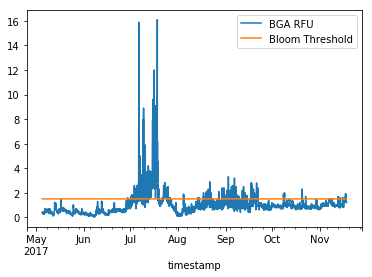

In [13]:
presegmented_plot.plot.line()

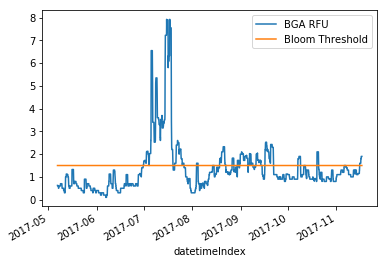

In [14]:
pd.DataFrame({'BGA RFU': train_dfs[train_index][target_column], 
            'Bloom Threshold': np.full(
                train_dfs[train_index].count()[0], RFU_THRESHOLD)}).plot.line()

## Logistic Regression Model

In [15]:
lrf.add_target_column([train_dfs[train_index], test_dfs[test_index]], 
                      threshold=RFU_THRESHOLD)

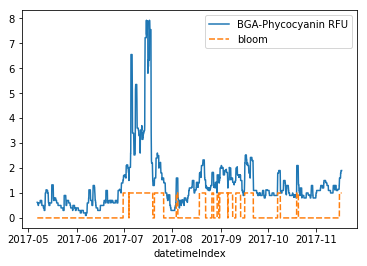

In [16]:
sns.lineplot(data=train_dfs[train_index][[target_column, 'bloom']], hue='bloom')

In [17]:
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
# Sort columns by accuracy
sorted_columns = lrf.sort_columns_by_metric(model, train_dfs[train_index], 
                                            test_dfs[test_index],
                                            x_columns,
                                            'bloom')

Training model with: Temp C
Accuracy 0.6207040199958342
Recall: 0.18778696051423324
Precision 0.8872017353579176
Confusion Matrix:
 [[2571   52]
 [1769  409]]

Training model with: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.5463445115600917
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2623    0]
 [2178    0]]

Training model with: pH (mV)
Accuracy 0.4536554884399083
Recall: 1.0
Precision 0.4536554884399083
Confusion Matrix:
 [[   0 2623]
 [   0 2178]]

Training model with: pH
Accuracy 0.6927723390960216
Recall: 0.9710743801652892
Precision 0.599659767507797
Confusion Matrix:
 [[1211 1412]
 [  63 2115]]

Training model with: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.5463445115600917
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[2623    0]
 [2178    0]]

Training model with: ODOSat%
Accuracy 0.7640074984378254
Recall: 0.6336088154269972
Precision 0.8046647230320699
Confusion Matrix:
 [[2288  335]
 [ 798 1380]]

Training model with: ODO (mg/L)
Accuracy 0.69693813788794
Recall: 0.588613406795225
Precision 0.6963606735469854
Confusion Matrix:
 [[2064  559]
 [ 896 1282]]

ODOSat% accuracy: 0.7640074984378254
ODO (mg/L) accuracy: 0.69693813788794
pH accuracy: 0.6927723390960216
Temp C accuracy: 0.6207040199958342
Sp Cond (uS/cm) accuracy: 0.5463445115600917
Turbidity (NTU) accuracy: 0.5463445115600917
pH (mV) accuracy: 0.4536554884399083


In [18]:
#create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 
                                            'bloom', sorted_columns)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training model with: ['ODOSat%']
Test model accuracy: 0.7640074984378254
Test model recall: 0.6336088154269972
Test model precision: 0.8046647230320699

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.7556759008539887
Test model recall: 0.6694214876033058
Test model precision: 0.7629513343799058

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH']
Test model accuracy: 0.7619245990418663
Test model recall: 0.7121212121212122
Test model precision: 0.7503628447024674

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C']
Test model accuracy: 0.7604665694646948
Test model recall: 0.721763085399449
Test model precision: 0.7429111531190926

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH', 'Temp C', 'Sp Cond (uS/cm)']
Test model accuracy: 0.7606748594042908
Test model recall: 0.7084481175390266
Test model precision: 0.7501215362177929

Training model with: ['ODOSat%'

Model AUC: 0.8487


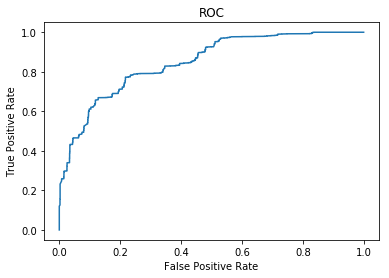

In [19]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)

## Random Forest Model

In [20]:
# All Inputs
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

Accuracy 0.575921682982712
Recall: 0.4398530762167126
Precision 0.5400225479143179
Confusion Matrix:
 [[1807  816]
 [1220  958]]


In [21]:
# Greedy Model
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom', sorted_columns)

Training model with: ['ODOSat%']


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Test model accuracy: 0.7229743803374297
Test model recall: 0.657483930211203
Test model precision: 0.7103174603174603

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.6529889606332014
Test model recall: 0.628099173553719
Test model precision: 0.6151079136690647

Training model with: ['ODOSat%', 'pH']
Test model accuracy: 0.6965215580087482
Test model recall: 0.4540863177226814
Test model precision: 0.786793953858393

Training model with: ['ODOSat%', 'Temp C']
Test model accuracy: 0.6727765048948136
Test model recall: 0.5748393021120294
Test model precision: 0.6599894570374275

Training model with: ['ODOSat%', 'Sp Cond (uS/cm)']
Test model accuracy: 0.6579879191835034
Test model recall: 0.4825528007346189
Test model precision: 0.6711366538952745

Training model with: ['ODOSat%', 'Turbidity (NTU)']
Test model accuracy: 0.7102686940220787
Test model recall: 0.5959595959595959
Test model precision: 0.7175234936428966

Training model with: ['ODOS

In [22]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_df[['bloom']].values, predictions)

NameError: name 'test_df' is not defined